<a href="https://colab.research.google.com/github/q-maze/location-affordability-tool/blob/main/CS_Semester_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as stats
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import statsmodels.api as sm
import datetime as dt

## Read in Data and clean up Data

In [7]:
# Read in data as pandas dataframe
# https://services.arcgis.com/VTyQ9soqVukalItT/arcgis/rest/services/LAIv1/FeatureServer/0/query?outFields=*&where=1%3D1
file = 'https://opendata.arcgis.com/datasets/8eaa0b89826244ae9246915199462328_0.csv'
data = pd.read_csv(file)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219829 entries, 0 to 219828
Columns: 123 entries, FID to SHAPE_Area
dtypes: float64(115), int64(6), object(2)
memory usage: 206.3+ MB
None


In [8]:
data = data.rename(columns={'FID': 'Object_ID', 'BlockGroups_GEOID10': '2010_Census_Geoid', 'BlockGroups_STATEFP10': 'State_ID', 'BlockGroups_COUNTYFP10': 'County_ID', 'SF1_BlockGroups_NAME': 'Name','SF1_BlockGroups_STATE_NAME': 'State', 'SF1_BlockGroups_ST_ABBREV': 'State_ABBREV'})
#data = data.drop(data.columns[4:6], axis=1)

# drop very low income because it is the same for every neighborhood
data = data.drop(data.columns[69:82], axis=1)

#filter for NaN 
data = data.dropna()

# or fillna with mean
#data = data.fillna(data.mean)

# add leading zeros to IDs

# combine state & county ID 
data["State_County_ID"]=data["State_ID"].astype(str) + data["County_ID"].astype(str)
data["State_County_ID"] = pd.to_numeric(data["State_County_ID"], downcast='integer')

# group by county

# Translate GeoID into label for metro areas

# What are the units of the data variables?

#check output
print(data.dtypes)
data.head()

Object_ID                   int64
2010_Census_Geoid           int64
State_ID                    int64
County_ID                   int64
BlockGroups_TRACTCE10       int64
                           ...   
hh_type8_vmt              float64
hh_type8_transit_trips    float64
SHAPE_Length              float64
SHAPE_Area                float64
State_County_ID             int32
Length: 111, dtype: object


,Object_ID,2010_Census_Geoid,State_ID,County_ID,BlockGroups_TRACTCE10,BlockGroups_BLKGRPCE10,Name,State,State_ABBREV,residential_density,gross_hh_density,block_denstiy,intersection_density,employment_access_index,job_diversity_index,average_median_commute_distance,per_capita_income,hh_type1_income,hh_type1_size,hh_type1_workers,hh_type1_ht,hh_type1_h,hh_type1_ht_own,hh_type1_h_own,hh_type1_ht_rent,hh_type1_h_rent,hh_type1_t,hh_type1_autos,hh_type1_vmt,hh_type1_transit_trips,hh_type2_income,hh_type2_size,hh_type2_workers,hh_type2_ht,hh_type2_h,hh_type2_ht_own,hh_type2_h_own,hh_type2_ht_rent,hh_type2_h_rent,hh_type2_t,...,hh_type6_workers,hh_type6_ht,hh_type6_h,hh_type6_ht_own,hh_type6_h_own,hh_type6_ht_rent,hh_type6_h_rent,hh_type6_t,hh_type6_autos,hh_type6_vmt,hh_type6_transit_trips,hh_type7_income,hh_type7_size,hh_type7_workers,hh_type7_ht,hh_type7_h,hh_type7_ht_own,hh_type7_h_own,hh_type7_ht_rent,hh_type7_h_rent,hh_type7_t,hh_type7_autos,hh_type7_vmt,hh_type7_transit_trips,hh_type8_income,hh_type8_size,hh_type8_workers,hh_type8_ht,hh_type8_h,hh_type8_ht_own,hh_type8_h_own,hh_type8_ht_rent,hh_type8_h_rent,hh_type8_t,hh_type8_autos,hh_type8_vmt,hh_type8_transit_trips,SHAPE_Length,SHAPE_Area,State_County_ID
0,1,10010201001,1,1,20100,1,1.001020e+07,Alabama,AL,1.18074,0.22802,0.02481,0.06774,4039.64242,2377.12702,13.4872,25018.34061,46404.0,2.52,1.07612,58.49384,32.97585,64.26989,38.75191,38.22315,12.70516,25.51798,1.91696,25679.36294,3.79043,37123.2,2.52,1.07612,67.83037,37.93335,74.41004,44.51303,44.73943,14.84241,29.89702,...,1.0,65.84365,42.12278,74.12964,50.40877,36.76451,13.04364,23.72087,1.48909,18962.28825,3.88963,18414.28571,1.0,1.0,106.67727,64.25599,118.96241,76.54113,63.56339,21.14211,42.42128,1.33630,17901.04557,4.60947,37123.2,2.0,0.0,64.19630,41.30819,72.03960,49.15149,36.67075,13.78264,22.88811,1.47285,18033.52446,2.03141,0.110807,0.000410,11
1,2,10010201002,1,1,20100,2,1.001020e+07,Alabama,AL,1.18649,0.33213,0.02253,0.05015,3151.21613,2469.12451,16.5752,25540.21739,46404.0,2.52,1.07612,50.84112,25.33012,51.20694,25.69594,47.49186,21.98086,25.51100,1.90654,25851.33811,2.70818,37123.2,2.52,1.07612,59.20424,29.31120,59.40468,29.51164,57.36912,27.47608,29.89304,...,1.0,56.64444,32.85011,57.20740,33.41308,51.49021,27.69589,23.79432,1.47966,19261.54225,2.58472,18414.28571,1.0,1.0,93.75684,51.17196,93.29594,50.71105,97.97666,55.39178,42.58489,1.32686,18198.43911,3.30700,37123.2,2.0,0.0,55.05128,32.00229,55.54565,32.49666,50.52507,27.47608,23.04899,1.47482,18307.12430,0.00000,0.096808,0.000534,11
2,3,10010202001,1,1,20200,1,1.001020e+07,Alabama,AL,1.45205,0.78051,0.02949,0.11993,4415.57319,2349.56864,15.7593,11964.35045,46404.0,2.52,1.07612,56.56345,32.14654,68.14667,43.72976,37.07546,12.65854,24.41691,1.84491,24379.70202,4.28453,37123.2,2.52,1.07612,65.60291,37.03088,78.83081,50.25878,43.34787,14.77584,28.57203,...,1.0,63.15488,40.49510,79.48494,56.82516,35.68066,13.02089,22.65978,1.41530,18233.62731,4.31585,18414.28571,1.0,1.0,102.52297,62.05880,126.89674,86.43257,61.51575,21.05158,40.46417,1.26798,17175.96205,5.14395,37123.2,2.0,0.0,60.99275,39.51995,76.38606,54.91326,35.09455,13.62175,21.47280,1.38761,16822.02776,1.09044,0.062129,0.000197,11
3,4,10010202002,1,1,20200,2,1.001020e+07,Alabama,AL,1.37288,1.05108,0.11679,0.19570,5384.02395,2330.26313,12.0583,19640.09434,46404.0,2.52,1.07612,47.86888,24.25007,53.38349,29.76468,40.54178,16.92296,23.61881,1.81002,23127.89339,5.19053,37123.2,2.52,1.07612,55.62868,28.02322,61.86410,34.25864,47.34385,19.73839,27.60546,...,1.0,51.32660,29.60049,60.46524,38.73913,39.18435,17.45824,21.72611,1.37532,17169.36431,5.47280,18414.28571,1.0,1.0,87.16859,48.46458,97.89510,59.19109,72.91658,34.21257,38.70401,1.23040,16154.44438,6.27060,37123.2,2.0,0.0,49.63211,29.41685,57.55352,37.33826,39.10716,18.89190,20.21526,1.33315,15372.06680,5.67717,0.052277,0.000124,11
4,5,10010203001,1,1,20300,1,1.001020e+07,Alabama,AL,1.05234,0.96919,0.02303,0.09838,4743.36174,2359.30268,14.3923,16666.55738,4640

In [9]:
# drop Hawaii, Alaska, and DC
data_cont = data.drop(data[(data['State']=='Hawaii') | (data['State']== 'Alaska') | (data['State']== 'District of Columbia')].index)
print(data_cont.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196564 entries, 0 to 217221
Columns: 111 entries, Object_ID to State_County_ID
dtypes: float64(102), int32(1), int64(6), object(2)
memory usage: 167.2+ MB
None


## Exploratory Data Analysis

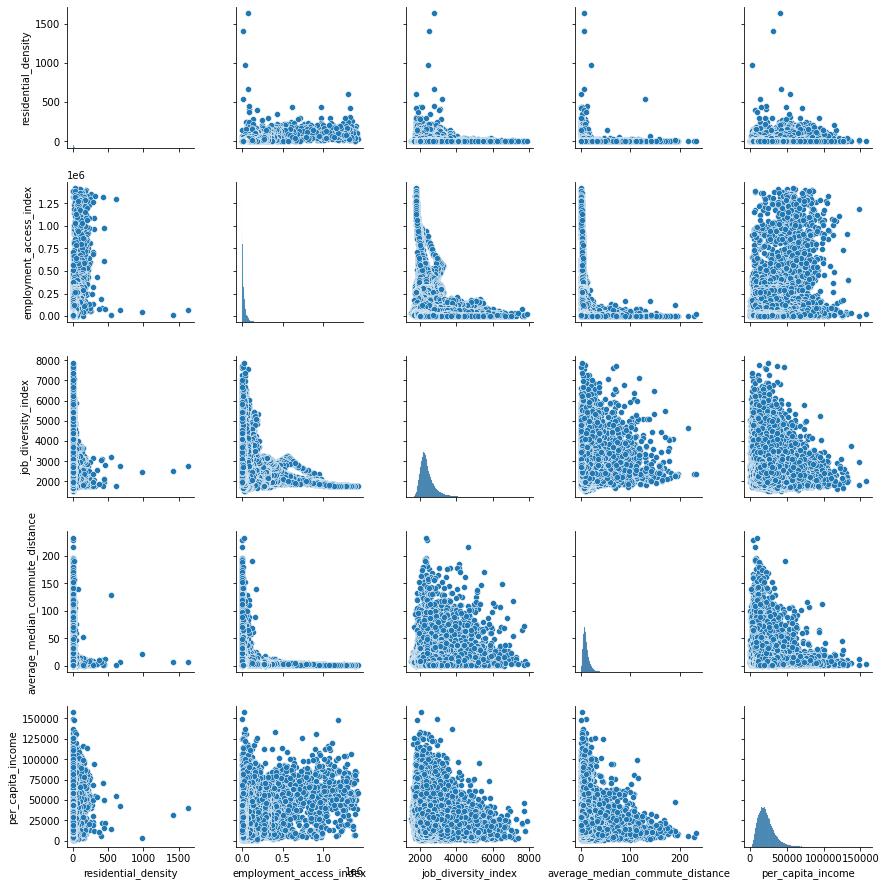

In [13]:
# Plot
data_cont_plot = data_cont[['residential_density','employment_access_index', 'job_diversity_index', 'average_median_commute_distance', 'per_capita_income']]
sns.pairplot(data_cont_plot, diag_kind='hist')

In [7]:
# Correlation of variables (response: per_capita_income)
variables = data_cont.iloc[:,7:17]
variables.corr()

,residential_density,gross_hh_density,block_denstiy,intersection_density,employment_access_index,job_diversity_index,average_median_commute_distance,per_capita_income
residential_density,1.000000,0.876800,0.347618,0.459561,0.638845,0.016871,-0.135656,0.034997
gross_hh_density,0.876800,1.000000,0.378421,0.522803,0.694360,0.018312,-0.160912,0.041703
block_denstiy,0.347618,0.378421,1.000000,0.916423,0.365199,0.065448,-0.252835,-0.126422
intersection_density,0.459561,0.522803,0.916423,1.000000,0.466372,0.047768,-0.272655,-0.086041
employment_access_index,0.638845,0.694360,0.365199,0.466372,1.000000,-0.071485,-0.205640,0.156373
job_diversity_index,0.016871,0.018312,0.065448,0.047768,-0.071485,1.000000,0.001754,-0.188491
average_median_commute_distance,-0.135656,-0.160912,-0.252835,-0.272655,-0.205640,0.001754,1.000000,-0.063531
per_capita_income,0.034997,0.041703,-0.126422,-0.086041,0.156373,-0.188491,-0.063531,1.000000


per_capita_income is not highly correlated with any other variables

In [10]:
# Multivariate linear regression (note: block_density typo intentional)
X = data_cont[['residential_density', 'average_median_commute_distance']]
Y = data_cont['employment_access_index']

X1 = sm.add_constant(X)
reg = sm.OLS(Y,X1).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     employment_access_index   R-squared:                       0.423
Model:                                 OLS   Adj. R-squared:                  0.423
Method:                      Least Squares   F-statistic:                 7.192e+04
Date:                     Thu, 22 Apr 2021   Prob (F-statistic):               0.00
Time:                             14:55:53   Log-Likelihood:            -2.4232e+06
No. Observations:                   196564   AIC:                         4.846e+06
Df Residuals:                       196561   BIC:                         4.846e+06
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            2.611e+04    209.773    124.473      0.000    2.57e+04    2.65e+04
residential_density              3452.8542      9.597    359.772      0.000    3434.044    3471.665
average_median_commute_distance  -933.5539     13.325    -70.063      0.000    -959.670    -907.438
==============================================================================
Omnibus:                   193767.273   Durbin-Watson:                   0.564
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      10217344317.490
Skew:                          -3.019   Prob(JB):                         0.00
Kurtosis:                    1119.905   Cond. No.                         27.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Moderate predictor for employment access.

In [11]:
X = data_cont[['job_diversity_index', 'average_median_commute_distance']]
Y = data_cont['per_capita_income']

X1 = sm.add_constant(X)
reg2 = sm.OLS(Y,X1).fit()

reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      per_capita_income   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     4044.
Date:                Thu, 22 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:55:59   Log-Likelihood:            -2.1181e+06
No. Observations:              196564   AIC:                         4.236e+06
Df Residuals:                  196561   BIC:                         4.236e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            3.464e+04    138.621    249.867      0.000    3.44e+04    3.49e+04
job_diversity_index                -4.6302      0.054    -85.220      0.000      -4.737      -4.524
average_median_commute_distance   -79.9445      2.796    -28.591      0.000     -85.425     -74.464
==============================================================================
Omnibus:                    63440.778   Durbin-Watson:                   0.766
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           277520.038
Skew:                           1.535   Prob(JB):                         0.00
Kurtosis:                       7.946   Cond. No.                     1.32e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Not a good predictor for per capita income.

In [ ]:
# highest income neighborhood
data_cont.sort_values("per_capita_income", ascending=False).head(25)

,Object_ID,2010_Census_Geoid,State_ID,County_ID,BlockGroups_TRACTCE10,BlockGroups_BLKGRPCE10,Name,State,State_ABBREV,residential_density,gross_hh_density,block_denstiy,intersection_density,employment_access_index,job_diversity_index,average_median_commute_distance,per_capita_income,hh_type1_income,hh_type1_size,hh_type1_workers,hh_type1_ht,hh_type1_h,hh_type1_ht_own,hh_type1_h_own,hh_type1_ht_rent,hh_type1_h_rent,hh_type1_t,hh_type1_autos,hh_type1_vmt,hh_type1_transit_trips,hh_type2_income,hh_type2_size,hh_type2_workers,hh_type2_ht,hh_type2_h,hh_type2_ht_own,hh_type2_h_own,hh_type2_ht_rent,hh_type2_h_rent,hh_type2_t,...,hh_type6_workers,hh_type6_ht,hh_type6_h,hh_type6_ht_own,hh_type6_h_own,hh_type6_ht_rent,hh_type6_h_rent,hh_type6_t,hh_type6_autos,hh_type6_vmt,hh_type6_transit_trips,hh_type7_income,hh_type7_size,hh_type7_workers,hh_type7_ht,hh_type7_h,hh_type7_ht_own,hh_type7_h_own,hh_type7_ht_rent,hh_type7_h_rent,hh_type7_t,hh_type7_autos,hh_type7_vmt,hh_type7_transit_trips,hh_type8_income,hh_type8_size,hh_type8_workers,hh_type8_ht,hh_type8_h,hh_type8_ht_own,hh_type8_h_own,hh_type8_ht_rent,hh_type8_h_rent,hh_type8_t,hh_type8_autos,hh_type8_vmt,hh_type8_transit_trips,SHAPE_Length,SHAPE_Area,State_County_ID
48697,48698,120990035041,12,99,3504,1,1.209900e+08,Florida,FL,1.22744,0.57627,0.05846,0.11275,2.104539e+04,2039.80551,2.87220,157233.33333,48839.0,2.66,1.16571,87.83812,65.91025,101.78208,79.85421,51.58383,29.65596,21.92787,1.84069,20413.80261,21.15845,39071.2,2.66,1.16571,107.23097,81.68847,125.36027,99.81777,60.09480,34.55230,25.54250,...,1.0,106.90070,86.91654,126.19027,106.20611,56.74782,36.76365,19.98417,1.32661,13983.22328,27.11790,18360.52632,1.0,1.0,209.05760,173.83307,247.63674,212.41221,108.75183,73.52730,35.22453,1.18760,12943.17327,28.43333,39071.2,2.0,0.0,99.31570,81.68847,117.44500,99.81777,52.17954,34.55230,17.62723,1.28640,12318.86168,61.94509,0.228682,0.000264,1299
45467,45468,120710802032,12,71,80203,2,1.207108e+08,Florida,FL,1.28180,1.02218,0.01319,0.12530,2.024636e+03,2961.27839,11.51710,148610.86957,50014.0,2.44,0.95361,101.40671,77.97817,101.40671,77.97817,46.30168,22.87313,23.42855,1.88341,24652.62307,0.00000,40011.2,2.44,0.95361,125.73516,97.47271,125.73516,97.47271,54.95974,26.69729,28.26245,...,1.0,117.82721,95.13336,117.82721,95.13336,45.86693,23.17308,22.69385,1.49430,19591.53943,0.00000,20497.54098,1.0,1.0,230.80342,190.26673,230.80342,190.26673,77.99467,37.45798,40.53670,1.34331,18519.57259,0.00000,40011.2,2.0,0.0,119.70757,97.47271,119.70757,97.47271,46.97408,24.73922,22.23486,1.48729,17737.21727,0.00000,0.070063,0.000056,1271
135541,135542,360610114012,36,61,11401,2,3.606101e+08,New York,NY,18.86742,18.86744,0.32956,0.82391,1.183129e+06,1831.89117,1.45680,147929.58580,63915.0,2.69,1.20119,33.80061,24.76874,41.88801,32.85614,29.02680,19.99493,9.03188,0.82409,7431.88118,1081.06081,51132.0,2.69,1.20119,40.05513,29.75795,51.36736,41.07017,33.37778,23.08059,10.29719,...,1.0,37.23143,31.01772,50.40522,44.19150,29.45524,23.24153,6.21371,0.35884,3692.98031,840.47952,23760.22305,1.0,1.0,69.75651,59.80051,98.33901,88.38301,52.88489,42.92889,9.95600,0.25840,2736.47472,850.30194,51132.0,2.0,0.0,36.94429,28.15817,49.85630,41.07017,29.32262,20.53649,8.78612,0.61110,5167.37378,1154.98514,0.009672,0.000005,3661
46688,46689,120860040006,12,86,4000,6,1.208600e+08,Florida,FL,3.14868,2.58035,0.16514,0.20643,3.747828e+04,3754.23053,5.32537,136931.44654,48839.0,2.66,1.16571,72.60768,55.28369,72.60768,55.28369,37.68362,20.35963,17.32399,1.51094,14458.30190,207.52779,39071.2,2.66,1.16571,89.07756,69.10461,89.07756,69.10461,43.72528,23.75233,19.97295,...,1.0,88.25379,73.52730,88.25379,73.52730,36.72670,22.00022,14.72648,1.03478,8831.79246,168.68656,18360.52632,1.0,1.0,172.18241,147.05461,172.18241,147.05461,60.63781,35.51000,25.12781,0.90530,7833.12367,171.02352,39071.2,2.0,0.0,83.15412,69.10461,83.15412,69.10461,36.80935,22.75984,14.04951,1.10828,7833.73449,223.78541,0.017993,0.000018,1286
60235,60236,170310812021,17

In [ ]:
# lowest income neighborhoods
data_cont.sort_values("per_capita_income", ascending=True).head(25)

,Object_ID,2010_Census_Geoid,State_ID,County_ID,BlockGroups_TRACTCE10,BlockGroups_BLKGRPCE10,Name,State,State_ABBREV,residential_density,gross_hh_density,block_denstiy,intersection_density,employment_access_index,job_diversity_index,average_median_commute_distance,per_capita_income,hh_type1_income,hh_type1_size,hh_type1_workers,hh_type1_ht,hh_type1_h,hh_type1_ht_own,hh_type1_h_own,hh_type1_ht_rent,hh_type1_h_rent,hh_type1_t,hh_type1_autos,hh_type1_vmt,hh_type1_transit_trips,hh_type3_income,hh_type3_size,hh_type3_workers,hh_type3_ht,hh_type3_h,hh_type3_ht_own,hh_type3_h_own,hh_type3_ht_rent,hh_type3_h_rent,hh_type3_t,...,hh_type6_workers,hh_type6_ht,hh_type6_h,hh_type6_ht_own,hh_type6_h_own,hh_type6_ht_rent,hh_type6_h_rent,hh_type6_t,hh_type6_autos,hh_type6_vmt,hh_type6_transit_trips,hh_type7_income,hh_type7_size,hh_type7_workers,hh_type7_ht,hh_type7_h,hh_type7_ht_own,hh_type7_h_own,hh_type7_ht_rent,hh_type7_h_rent,hh_type7_t,hh_type7_autos,hh_type7_vmt,hh_type7_transit_trips,hh_type8_income,hh_type8_size,hh_type8_workers,hh_type8_ht,hh_type8_h,hh_type8_ht_own,hh_type8_h_own,hh_type8_ht_rent,hh_type8_h_rent,hh_type8_t,hh_type8_autos,hh_type8_vmt,hh_type8_transit_trips,SHAPE_Length,SHAPE_Area,State_County_ID
193547,193548,483090004001,48,309,400,1,4.830900e+08,Texas,TX,1.05920,0.65776,0.18356,0.43595,25174.02745,3388.25094,46.06410,342.32877,40672.0,2.68,1.15959,34.42726,9.38792,64.00775,38.96842,34.42726,9.38792,25.03934,1.74034,20455.36966,32.01716,61008.0,4.0,2.0,27.10331,3.44217,51.97818,28.31705,27.10331,3.44217,23.66114,...,1.0,32.19182,9.89135,75.63170,53.33123,32.19182,9.89135,22.30047,1.24983,13052.38298,26.68329,15176.11940,1.0,1.0,55.34097,16.26349,121.25949,82.18201,55.34097,16.26349,39.07748,1.11245,12059.26098,27.20357,32537.6,2.0,0.0,30.00633,11.17056,68.64830,49.81253,30.00633,11.17056,18.83577,1.18043,10997.13910,22.35726,0.031041,0.000050,48309
160035,160036,401091030002,40,109,103000,2,4.010910e+08,Oklahoma,OK,2.25898,0.86376,0.13087,0.49731,65759.31205,2619.43011,5.26597,490.96267,46999.0,2.53,1.15972,43.65405,23.97964,50.21638,30.54197,38.18544,18.51103,19.67441,1.66227,16742.91447,20.47669,70498.5,4.0,2.0,36.02537,16.87650,41.46835,22.31948,31.48956,12.34069,19.14887,...,1.0,47.55757,30.98697,56.64219,40.07159,39.98705,23.41646,16.57059,1.18864,10760.88339,18.43408,18576.67984,1.0,1.0,82.21511,53.49415,90.20860,61.48765,75.55387,46.83291,28.72096,1.05821,9750.99744,18.93817,37599.2,2.0,0.0,44.67586,30.20418,53.15433,38.68264,37.61048,23.13879,14.47169,1.10115,8629.74108,28.52958,0.019195,0.000015,40109
130790,130791,360299401001,36,29,940100,1,3.602994e+08,New York,NY,0.00000,0.00340,0.00340,0.00425,2866.01410,2220.97425,20.47880,526.10526,47093.0,2.37,1.05489,63.37323,31.74547,63.37323,31.74547,46.48234,14.85458,31.62775,2.22304,32530.89596,14.74289,70639.5,4.0,2.0,50.70156,22.24794,50.70156,22.24794,40.50904,12.05542,28.45362,...,1.0,68.43331,39.79363,68.43331,39.79363,43.07529,14.43562,28.63968,1.82662,24279.94958,14.15568,19870.46414,1.0,1.0,111.80624,59.79408,111.80624,59.79408,75.70428,23.69212,52.01216,1.65488,23193.76626,14.15568,37674.4,2.0,0.0,71.80337,41.35843,71.80337,41.35843,47.55517,17.11023,30.44493,1.83498,24608.54443,3.45705,0.118855,0.000526,3629
159237,159238,400310024032,40,31,2403,2,4.003100e+08,Oklahoma,OK,0.39441,0.02690,0.04322,0.08644,2789.32851,2766.83137,99.00370,556.57016,44012.0,2.48,1.06712,50.59915,20.01498,57.56527,26.98110,50.59915,20.01498,30.58417,1.99610,31572.88803,62.53395,66018.0,4.0,2.0,43.65500,15.17263,47.57408,19.09171,43.65500,15.17263,28.48237,...,1.0,52.91897,22.22014,64.05225,33.35342,52.91897,22.22014,30.69883,1.73697,24931.92621,61.91929,17746.77419,1.0,1.0,92.34835,35.87667,108.67287,52.20118,92.34835,35.87667,56.47169,1.57948,24309.76593,63.47211,35209.6,2.0,0.0,51.30388,25.34040,61.18388,35.22040,51.30388,25.34040,25.96347,1.51041,19806.92196,98.73891,0.181233,0.000902,4031
39494,39495,90138812001,9,13,881200,1,9.013881e+07,Connecticut,CT,0.73979,0.07658,

In [ ]:
# highest residential density neighborhoods
data_cont.sort_values("residential_density",ascending=False).head(25)

,Object_ID,2010_Census_Geoid,State_ID,County_ID,BlockGroups_TRACTCE10,BlockGroups_BLKGRPCE10,Name,State,State_ABBREV,residential_density,gross_hh_density,block_denstiy,intersection_density,employment_access_index,job_diversity_index,average_median_commute_distance,per_capita_income,hh_type1_income,hh_type1_size,hh_type1_workers,hh_type1_ht,hh_type1_h,hh_type1_ht_own,hh_type1_h_own,hh_type1_ht_rent,hh_type1_h_rent,hh_type1_t,hh_type1_autos,hh_type1_vmt,hh_type1_transit_trips,hh_type3_income,hh_type3_size,hh_type3_workers,hh_type3_ht,hh_type3_h,hh_type3_ht_own,hh_type3_h_own,hh_type3_ht_rent,hh_type3_h_rent,hh_type3_t,...,hh_type6_workers,hh_type6_ht,hh_type6_h,hh_type6_ht_own,hh_type6_h_own,hh_type6_ht_rent,hh_type6_h_rent,hh_type6_t,hh_type6_autos,hh_type6_vmt,hh_type6_transit_trips,hh_type7_income,hh_type7_size,hh_type7_workers,hh_type7_ht,hh_type7_h,hh_type7_ht_own,hh_type7_h_own,hh_type7_ht_rent,hh_type7_h_rent,hh_type7_t,hh_type7_autos,hh_type7_vmt,hh_type7_transit_trips,hh_type8_income,hh_type8_size,hh_type8_workers,hh_type8_ht,hh_type8_h,hh_type8_ht_own,hh_type8_h_own,hh_type8_ht_rent,hh_type8_h_rent,hh_type8_t,hh_type8_autos,hh_type8_vmt,hh_type8_transit_trips,SHAPE_Length,SHAPE_Area,State_County_ID
59970,59971,170310307022,17,31,30702,2,1.703103e+08,Illinois,IL,1635.34506,390.51257,1.98230,0.99115,6.887943e+04,2787.64219,6.98017,40579.01235,60574.0,2.70,1.21097,29.24915,23.42113,29.57101,23.74299,27.64962,21.82159,5.82803,0.00000,8596.51550,1439.84006,90861.0,4.0,2.0,20.27369,16.51604,21.80323,18.04558,12.67237,8.91472,3.75765,...,1.0,36.92912,30.46766,37.49145,31.02999,34.13451,27.67305,6.46146,0.00000,6691.20784,1251.01750,22434.81481,1.0,1.0,61.94614,49.66263,63.09739,50.81388,56.22478,43.94127,12.28351,0.00000,5944.35586,1265.47993,48459.2,2.0,0.0,35.85995,26.66254,37.70363,28.50622,26.69742,17.50001,9.19741,0.04257,12379.96502,1408.26520,0.002923,4.435515e-07,1731
45017,45018,120710012012,12,71,1201,2,1.207100e+08,Florida,FL,1413.87784,0.11665,0.01304,0.03431,1.075926e+04,2497.80908,6.02757,31365.15152,50014.0,2.44,0.95361,30.49065,17.39513,49.13844,36.04292,30.49065,17.39513,13.09552,0.85812,16360.63156,266.81976,75021.0,4.0,2.0,23.63604,11.59675,37.99642,25.95713,23.63604,11.59675,12.03929,...,1.0,32.95532,21.22206,55.25902,43.52576,32.95532,21.22206,11.73327,0.71790,10315.60730,267.65473,20497.54098,1.0,1.0,85.08606,65.74410,87.56153,68.21958,85.08606,65.74410,19.34195,0.56840,9243.47352,275.18702,40011.2,2.0,0.0,34.84127,21.76753,58.44128,45.36755,34.84127,21.76753,13.07374,0.50949,15887.73809,279.37344,0.108088,5.505601e-04,1271
156030,156031,391130017002,39,113,1700,2,3.911300e+08,Ohio,OH,973.17262,1.47012,0.20378,0.45123,3.968496e+04,2444.88054,20.58830,3114.09692,47381.0,2.38,1.05352,19.61635,10.41660,43.71211,34.51236,19.61635,10.41660,9.19974,0.59926,8775.52334,495.95964,71071.5,4.0,2.0,16.56935,10.31741,32.03888,25.78694,16.56935,10.31741,6.25194,...,1.0,20.01986,13.72520,47.68920,41.39454,20.01986,13.72520,6.29466,0.38416,5230.63753,176.65465,19907.98319,1.0,1.0,31.29734,21.97883,74.44702,65.12851,31.29734,21.97883,9.31851,0.22667,4583.41232,208.79534,37904.8,2.0,0.0,23.85060,8.50072,57.47507,42.12518,23.85060,8.50072,15.34989,1.03803,9425.25626,465.85083,0.032311,6.406563e-05,39113
59969,59970,170310307021,17,31,30702,1,1.703103e+08,Illinois,IL,664.23735,664.23793,0.95988,2.87964,6.936969e+04,2782.45346,6.73180,42409.39597,60574.0,2.70,1.21097,35.71558,28.47070,39.04252,31.79765,26.59796,19.35308,7.24487,0.31837,8126.80760,1253.36180,90861.0,4.0,2.0,26.54367,20.54159,30.30430,24.30223,16.23749,10.23541,6.00208,...,1.0,42.73353,36.86454,47.53146,41.66247,29.58461,23.71561,5.86900,0.02079,5976.29434,1092.21130,22434.81481,1.0,1.0,70.84489,60.18552,77.68007,67.02070,52.11280,41.45343,10.65937,0.00000,5121.78136,1104.91469,48459.2,2.0,0.0,40.79328,32.94365,45.81136,37.96173,27.04104,19.19140,7.84964,0.16960,8219.20276,1232.31238,0.002771,4.579524e-07,1731
135463,135464,360610088007,36,61,8800,7,3.606101e+

In [ ]:
# lowest 25 residential density neighborhoods
data.sort_values('residential_density',ascending=True).head(25) #filter by >0

,Object_ID,2010_Census_Geoid,State_ID,County_ID,BlockGroups_TRACTCE10,BlockGroups_BLKGRPCE10,Name,State,State_ABBREV,residential_density,gross_hh_density,block_denstiy,intersection_density,employment_access_index,job_diversity_index,average_median_commute_distance,per_capita_income,hh_type1_income,hh_type1_size,hh_type1_workers,hh_type1_ht,hh_type1_h,hh_type1_ht_own,hh_type1_h_own,hh_type1_ht_rent,hh_type1_h_rent,hh_type1_t,hh_type1_autos,hh_type1_vmt,hh_type1_transit_trips,hh_type3_income,hh_type3_size,hh_type3_workers,hh_type3_ht,hh_type3_h,hh_type3_ht_own,hh_type3_h_own,hh_type3_ht_rent,hh_type3_h_rent,hh_type3_t,...,hh_type6_workers,hh_type6_ht,hh_type6_h,hh_type6_ht_own,hh_type6_h_own,hh_type6_ht_rent,hh_type6_h_rent,hh_type6_t,hh_type6_autos,hh_type6_vmt,hh_type6_transit_trips,hh_type7_income,hh_type7_size,hh_type7_workers,hh_type7_ht,hh_type7_h,hh_type7_ht_own,hh_type7_h_own,hh_type7_ht_rent,hh_type7_h_rent,hh_type7_t,hh_type7_autos,hh_type7_vmt,hh_type7_transit_trips,hh_type8_income,hh_type8_size,hh_type8_workers,hh_type8_ht,hh_type8_h,hh_type8_ht_own,hh_type8_h_own,hh_type8_ht_rent,hh_type8_h_rent,hh_type8_t,hh_type8_autos,hh_type8_vmt,hh_type8_transit_trips,SHAPE_Length,SHAPE_Area,State_County_ID
88515,88516,240317006043,24,31,700604,3,2.403170e+08,Maryland,MD,0.0,0.10808,0.00265,0.00942,14770.54205,1848.53209,13.61340,65264.81481,85660.0,2.64,1.33359,55.37798,38.52440,55.37798,38.52440,28.26024,11.40667,16.85358,2.27334,28503.98862,114.30265,128490.0,4.0,2.0,41.75598,26.15204,41.75598,26.15204,24.60240,8.99847,15.60394,...,1.0,66.28240,50.85221,66.28240,50.85221,27.50531,12.07512,15.43019,1.59898,19158.01319,115.62908,32446.96970,1.0,1.0,128.60474,101.70441,128.60474,101.70441,46.18036,19.28003,26.90033,1.45111,18070.11543,115.62908,68528.0,2.0,0.0,63.07021,48.15550,63.07021,48.15550,28.28576,13.37104,14.91472,1.67998,18652.65676,125.91480,0.189737,0.001434,2431
193161,193162,482819501002,48,281,950100,2,4.828195e+08,Texas,TX,0.0,0.00240,0.00154,0.00417,948.05677,2437.26419,43.27970,16199.55157,48228.0,2.86,1.27695,61.03024,27.20362,64.35757,30.53096,41.91321,8.08659,33.82662,2.43815,39196.12922,2.81158,72342.0,4.0,2.0,47.59179,19.58902,50.06296,22.06018,33.39383,5.39106,28.00277,...,1.0,76.15381,41.66498,78.58530,44.09646,62.18385,27.69502,34.48883,1.88398,27061.41220,1.55256,16862.93706,1.0,1.0,126.11863,63.43821,129.21677,66.53634,108.31846,45.63804,62.68043,1.70410,25970.42485,1.55256,38582.4,2.0,0.0,70.69871,39.39291,72.56558,41.25979,59.97266,28.66686,31.30579,1.96561,27947.52620,0.00000,1.626868,0.059267,48281
158893,158894,400198924001,40,19,892400,1,4.001989e+08,Oklahoma,OK,0.0,0.00621,0.00158,0.00567,985.01093,2298.79222,19.72110,14005.01672,39172.0,2.59,1.07722,64.29032,27.54902,65.19345,28.45215,54.35592,17.61462,36.74130,2.22140,34499.07236,8.71835,58758.0,4.0,2.0,51.15065,19.19491,51.82809,19.87235,43.69882,11.74308,31.95574,...,1.0,74.20744,37.16836,75.51266,38.47358,59.85002,22.81094,37.03908,1.80161,25654.66097,7.27882,15124.32432,1.0,1.0,124.38395,57.18473,125.43512,58.23590,112.82109,45.62187,67.19922,1.62577,24563.80991,7.27882,31337.6,2.0,0.0,72.25776,36.13740,73.54132,37.42096,58.13864,22.01828,36.12036,1.83436,25719.79694,0.00000,0.542374,0.015286,4019
138198,138199,360810383021,36,81,38302,1,3.608104e+08,New York,NY,0.0,0.01604,0.21831,0.46959,143840.94974,2553.75766,7.69522,29725.60976,63915.0,2.69,1.20119,48.24711,32.69505,51.86706,36.31500,48.24711,32.69505,15.55206,1.51043,16913.96375,781.53060,95872.5,4.0,2.0,37.15063,23.18977,40.44530,26.48444,37.15063,23.18977,13.96086,...,1.0,47.19918,35.39071,60.97794,49.16947,47.19918,35.39071,11.80847,0.94210,7871.04068,604.47332,23760.22305,1.0,1.0,77.33708,57.28206,94.65479,74.59977,77.33708,57.28206,20.05502,0.80048,6887.67359,604.47332,51132.0,2.0,0.0,57.22016,43.95768,60.77070,47.50822,57.22016,43.95768,13.26248,1.18255,8499.70193,779.59757,0.167590,0.000543,3681
138471,138472,360810561001,36,81,56100,1,3.608106e+08,New York,NY,0.0,0.02729,0.0

NY County 61: 3 highest income neighborhoods and 11 highest residential density, but no overlap.



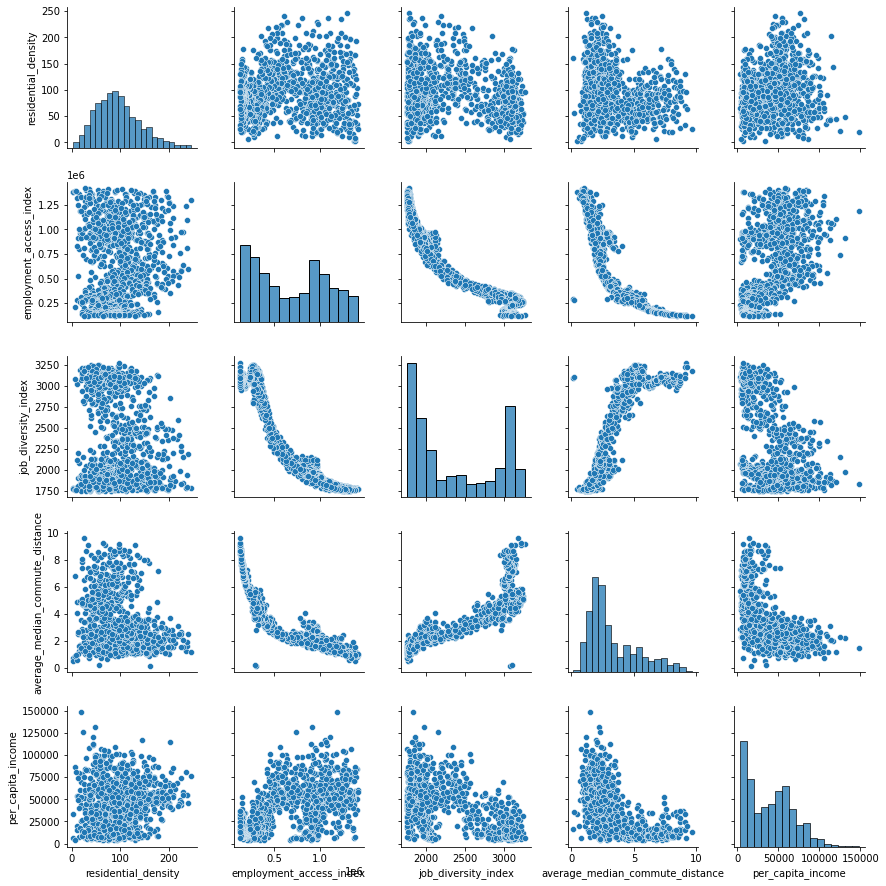

In [21]:
# Filter by State_County_ID 3661
data_ny_61 = pd.DataFrame(data_cont[data_cont["State_County_ID"]==3661])
data_ny_61 = data_ny_61[(data_ny_61['residential_density']<250)] # remove outliers
#data_ny_61.sort_values("residential_density",ascending=False).head(25)
#data_ny_61_density = pd.DataFrame(data_ny_61[data_ny_61["residential_density"]<201])

ny_61_plot = data_ny_61[['residential_density','employment_access_index', 'job_diversity_index', 'average_median_commute_distance', 'per_capita_income']]
sns.pairplot(ny_61_plot, diag_kind='hist')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Plot of Per Capita Income against Residential Density in NY County 61')

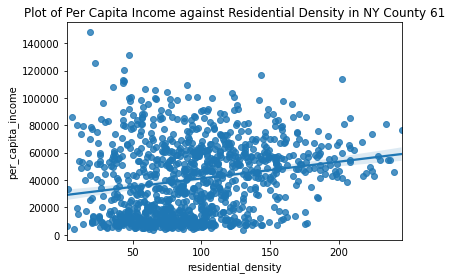

In [22]:
# Scatter Plot
sns.regplot('residential_density','per_capita_income',data=data_ny_61)
plt.title('Plot of Per Capita Income against Residential Density in NY County 61')

In [ ]:
# Group by states for Typical Income and Housing Costs
states_grouped = pd.DataFrame(data_cont.groupby('State')["per_capita_income"].mean())
states_grouped["Regional_Typical_Income"] = data_cont.groupby('State')["hh_type1_income"].mean()
states_grouped["Regional_Typical_Housing_Costs"] = data_cont.groupby('State')["hh_type1_h"].mean()
states_grouped["Regional_Typical_Transportation_Costs"] = data_cont.groupby('State')["hh_type1_t"].mean()
states_grouped.sort_values("Regional_Typical_Income", ascending=False)

,per_capita_income,Regional_Typical_Income,Regional_Typical_Housing_Costs,Regional_Typical_Transportation_Costs
State,,,,
Maryland,28909.544119,72169.843307,27.644028,15.915776
Connecticut,29741.316206,68666.560824,29.977176,16.740476
Massachusetts,28051.395999,65067.952848,30.568435,16.412726
Virginia,28098.300823,64307.935568,27.994364,18.791304
New Hampshire,26249.922118,63615.543800,29.780158,19.853397
New Jersey,28477.648284,62979.311483,34.755507,16.556874
California,24466.754771,61802.480319,33.752882,18.073490
Minnesota,25128.073716,59690.464317,27.017890,19.095095
New York,24701.682803,59315.182817,30.629827,15.662706


In [ ]:
# Income by household profiles grouped by state
state_income_profiles = pd.DataFrame(data_cont.groupby('State')["per_capita_income"].mean())
state_income_profiles["Regional_Typical_Income"] = data_cont.groupby('State')["hh_type1_income"].mean()
state_income_profiles["Regional_Moderate_Income"] = data_cont.groupby('State')["hh_type2_income"].mean()
state_income_profiles["Dual_Income"] = data_cont.groupby('State')["hh_type3_income"].mean()
state_income_profiles["Low_Income"] = data_cont.groupby('State')["hh_type4_income"].mean()
#state_income_profiles["Very_Low_Income"] = data.groupby('State')["hh_type5_income"].mean() # consistent for every state
state_income_profiles["Single_Professional_Income"] = data_cont.groupby('State')["hh_type6_income"].mean()
state_income_profiles["Single_Worker_Income"] = data_cont.groupby('State')["hh_type7_income"].mean()
state_income_profiles["Retirees_Income"] = data_cont.groupby('State')["hh_type8_income"].mean()
state_income_profiles.sort_values("Low_Income", ascending=True)

# set up line chart to show gap from low-typical-dual

,per_capita_income,Regional_Typical_Income,Regional_Moderate_Income,Dual_Income,Low_Income,Single_Professional_Income,Single_Worker_Income,Retirees_Income
State,,,,,,,,
Mississippi,15754.276964,39280.924877,31424.739901,58921.387315,22667.918719,29911.361681,14955.680841,31424.739901
Arkansas,16937.668209,41062.688232,32850.150585,61594.032348,23403.419593,32644.760359,16322.380181,32850.150585
West Virginia,17096.502209,41282.495748,33025.996599,61923.743622,23639.115646,34118.608751,17059.304375,33025.996599
New Mexico,18610.745944,44649.029133,35719.223307,66973.543700,24588.383103,34414.192284,17207.096144,35719.223307
Louisiana,17575.014644,44384.358592,35507.486874,66576.537888,25172.098922,33870.437250,16935.218623,35507.486874
Oklahoma,18677.055788,44577.553122,35662.042498,66866.329684,25196.492295,35530.946894,17765.473447,35662.042498
Alabama,17685.530713,43416.379357,34733.103485,65124.569035,25288.304290,34429.210417,17214.605209,34733.103485
Tennessee,18886.567725,44611.211988,35688.969590,66916.817982,25584.039043,35685.667827,17842.833916,35688.969590
South Carolina,18650.783780,44647.255205,35717.804164,66970.882807,25747.020818,35689.853085,17844.926543,35717.804164


Text(0.5, 1.0, 'Typical Household Income for Regions in each State')

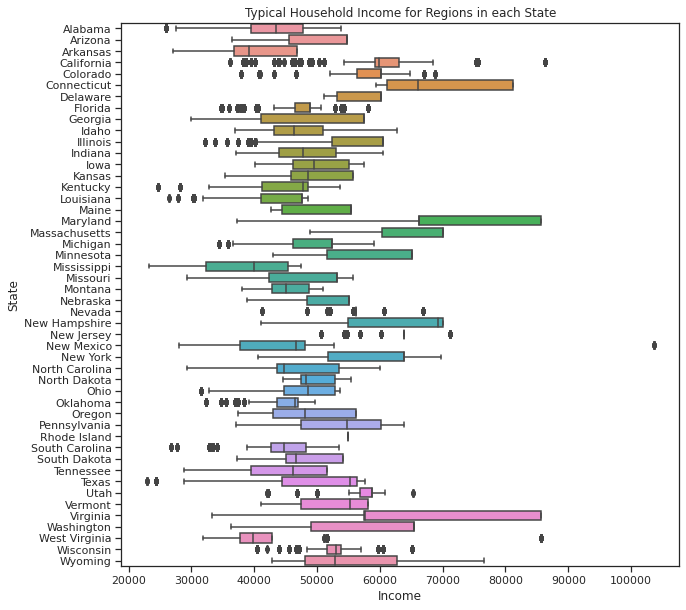

In [ ]:
# Boxplot of typical income for regions in each state
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize = (10,10))

sns.boxplot(x="hh_type1_income", y="State", data = data_cont)

#sns.stripplot(x="hh_type1_income", y="State", data = data, size = 1, color=".3") #Add all observations

plt.xlabel("Income")
# sort y axis by income level
# add meanline
plt.title("Typical Household Income for Regions in each State")

In [ ]:
# Income profiles
income_profiles = pd.DataFrame(data_cont["hh_type1_income"])
income_profiles = income_profiles.rename(columns={"hh_type1_income": "Regional_Typical_Income"})
income_profiles["Regional_Moderate_Income"]=data_cont["hh_type2_income"]
income_profiles["Dual_Income"]=data_cont["hh_type3_income"]
income_profiles["Low_Income"]=data_cont["hh_type4_income"]
income_profiles["Single_Professional_Income"]=data_cont["hh_type6_income"]
income_profiles["Single_Worker_Income"]=data_cont["hh_type7_income"]
income_profiles["Retirees_Income"]=data_cont["hh_type8_income"]

Text(0.5, 1.0, 'Income distribution of each profile')

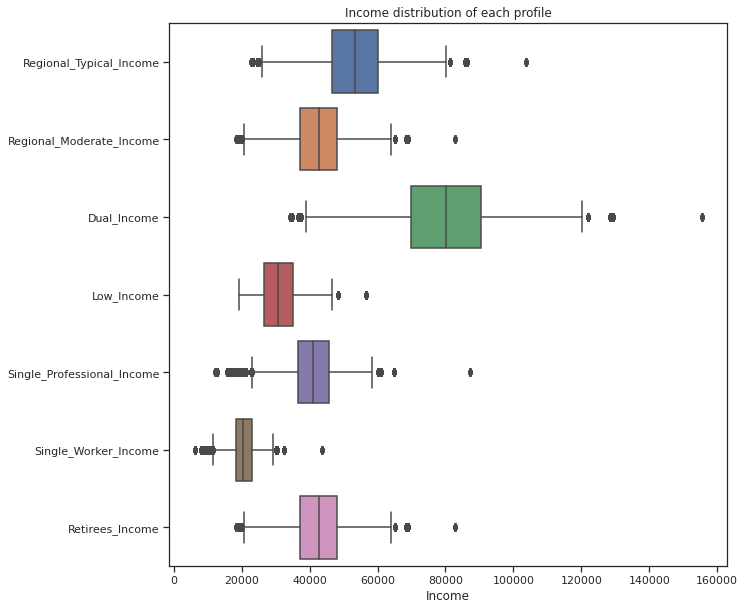

In [ ]:
# Boxplot of income profiles
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize = (10,10))

sns.boxplot(data = income_profiles, orient="h")

#sns.swarmplot(xdata = income_profiles, size = 1, color=".3") #Add all observations

plt.xlabel("Income")
# add meanline
plt.title("Income distribution of each profile")